# Age & Gender Detection with CNN

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with range from 0 to 116 years old. It consists of over 23,708 face images with labels of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

Since the dataset is `aligned and cropped` faces available to train the model. Have to say that any face input for testing must be cropped and aligned vertically to large extent.

In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
#from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image
from keras import optimizers,utils
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [2]:
# Mounting the directory for the dataset to be read.
dataset_folder = '../input/utkface-new/UTKFace/'
training_split = 0.8
image_width = image_height = 198

dataset_dict = {
    'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
    'gender_id': {0: 'male', 1: 'female'}
}

dataset_dict['gender_temp'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_temp'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [3]:
# Function to extract the data from our dataset by iterating over each file of the UTK dataset and
# return a Pandas Dataframe with all the fields (age, gender and sex).

def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):  #Parsing info from a file

        try:
            file_name = os.path.split(path)[1]
            file_name = os.path.splitext(file_name)[0]
            age, gender, race, _ = file_name.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info) # To place new items in the available space

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']


    df = df.dropna() # To remove the rows that contains NULL values.

    return df

In [4]:
df = parse_dataset(dataset_folder)
df.head()

,age,gender,race,file
0,100,male,white,../input/utkface-new/UTKFace\100_0_0_201701122...
1,100,male,white,../input/utkface-new/UTKFace\100_0_0_201701122...
2,100,female,white,../input/utkface-new/UTKFace\100_1_0_201701101...
3,100,female,white,../input/utkface-new/UTKFace\100_1_0_201701122...
4,100,female,white,../input/utkface-new/UTKFace\100_1_0_201701122...


In [5]:
df.info()       # No NAN values, means our dataset is already clean.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     23708 non-null  int64 
 1   gender  23708 non-null  object
 2   race    23708 non-null  object
 3   file    23708 non-null  object
dtypes: int64(1), object(3)
memory usage: 741.0+ KB


In [6]:
df.describe() # Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


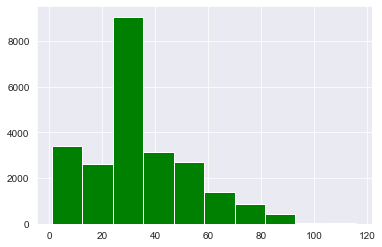

In [7]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Since the population is mostly between 20-30 age group, the dataset is not very well-balanced.

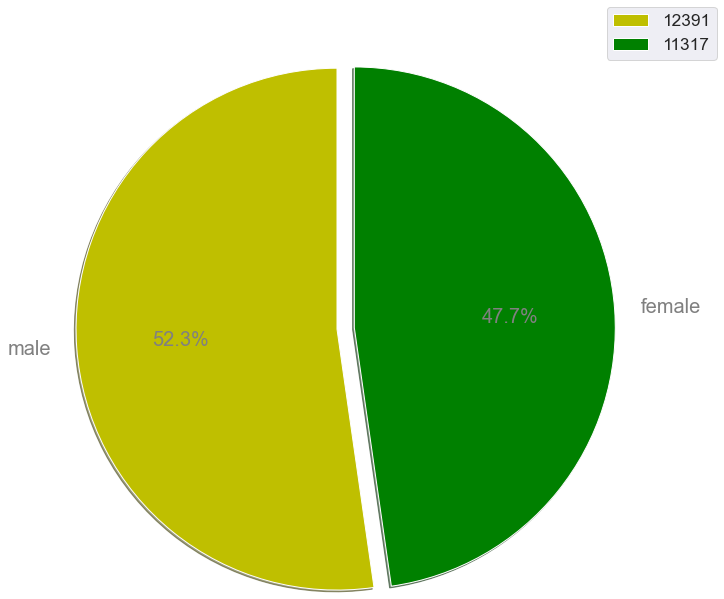

In [8]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g']
explode = (0, 0.2)  # explode the 2nd slice (i.e. 'female')
plt.pie(gender,labels = labels,
        colors = colors,
        explode=explode,
        radius=3,
        shadow=True,
        autopct='%.1f%%',
        textprops={'color':"gray", 'size':20},
        startangle=90)
plt.legend(gender, bbox_to_anchor=(1.7, 1.7), fontsize='xx-large')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data.
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

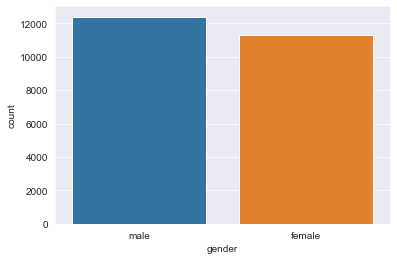

In [9]:
sns.countplot(x='gender', data=df);

# Males ~ Over 12k
# Females ~ Close to 12k

In [10]:
# Mean age by gender
df.groupby(['gender']).mean()

,age
gender,
female,30.684280
male,35.695666


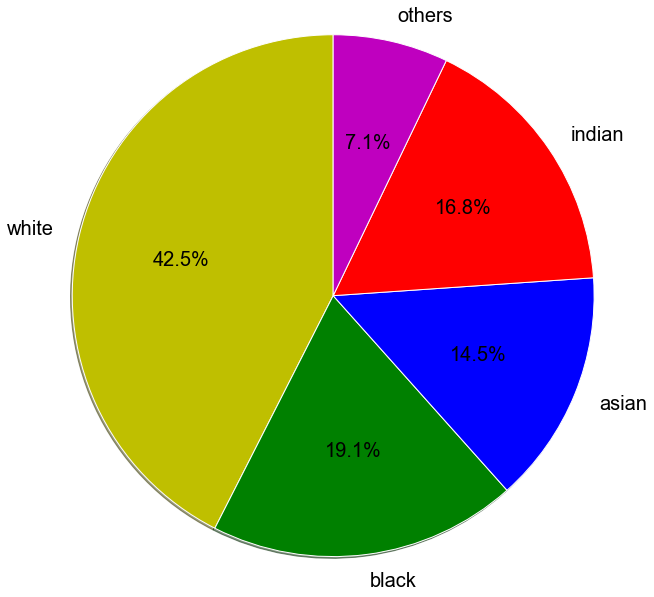

In [11]:
white = (df.race=='white').sum()
black = (df.race=='black').sum()
asian = (df.race=='asian').sum()
indian = (df.race=='indian').sum()
others = (df.race=='others').sum()

gender = [white,black,asian,indian,others]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m']
plt.pie(gender,
        labels = labels,
        colors = colors,
        radius=3,
        shadow=True,
        autopct='%.1f%%',
        textprops={'color':"black", 'size':20},
        startangle=90)
plt.show()

In [12]:
# Mean age by race
df.groupby(['race']).mean()

,age
race,
asian,25.877729
black,33.861498
indian,31.540241
others,23.169031
white,37.980949


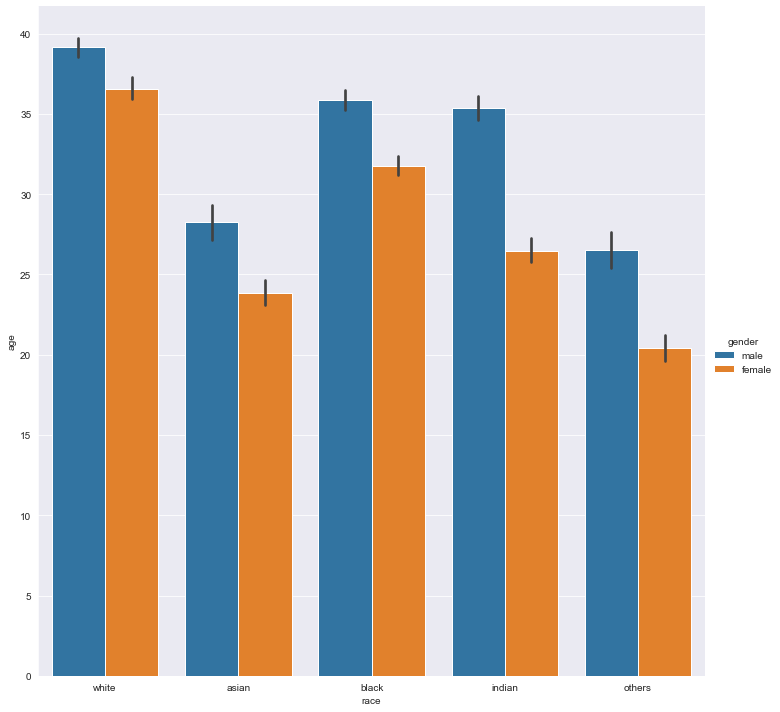

In [13]:
# Gives the mean age of both genders of all races
sns.catplot(x='race', y='age', hue='gender', data=df,kind='bar', height=10);

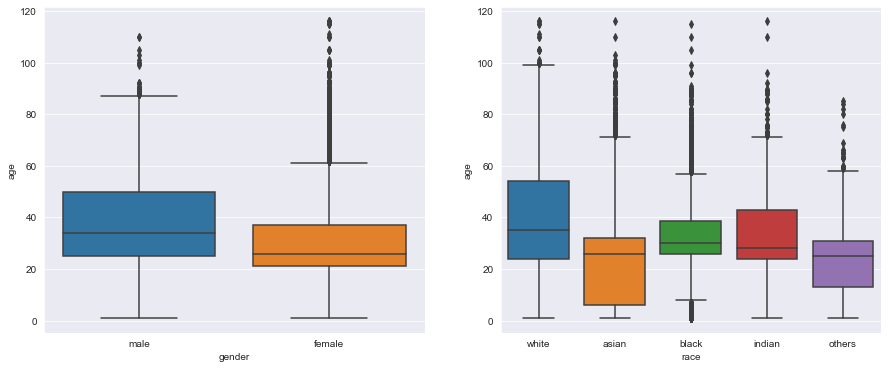

In [14]:
# We see that most of the males are between 25 and 55, whereas most of the females are between 20 and 40.
# Grouping by race, there is good amount of variations in different races.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

In [15]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups -
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ', y,' ', z,' ', a,' ', b, ' ', c,' ')

6903   11816   3990   967   32   0  


In [16]:
df.head()

,age,gender,race,file
0,4,male,white,../input/utkface-new/UTKFace\100_0_0_201701122...
1,4,male,white,../input/utkface-new/UTKFace\100_0_0_201701122...
2,4,female,white,../input/utkface-new/UTKFace\100_1_0_201701101...
3,4,female,white,../input/utkface-new/UTKFace\100_1_0_201701122...
4,4,female,white,../input/utkface-new/UTKFace\100_1_0_201701122...


In [17]:
# Data image generator
from keras.utils import to_categorical
from PIL import Image, ImageFont
p = np.random.permutation(len(df))

# Train_idx, valid_idx, for training the dataset with over 20k images by generating batches with images to train and validate at the same time.
train_up_to = int(len(df) * training_split)
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts temps to ids
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_temp'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_temp'][race])

# Minor preprocessing on the image to transfer into the model.
def preprocess_image(img_path):

    im = Image.open(img_path)
    im = im.resize((image_width, image_height))
    im = np.array(im) / 255.0

    return im

# To generate a batch with images when training/validating our model.
def generate_images(image_idx, is_training, batch_size=16):

    images, ages, races, genders = [], [], [], [] # arrays for the batched data

    while True:
        for idx in image_idx:
            person = df.iloc[idx]

            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']

            im = preprocess_image(file)

            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)

            # yielding condition: To return the yielded value (images) to the caller when you execute the function below for training and validating.
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []

        if not is_training:
            break

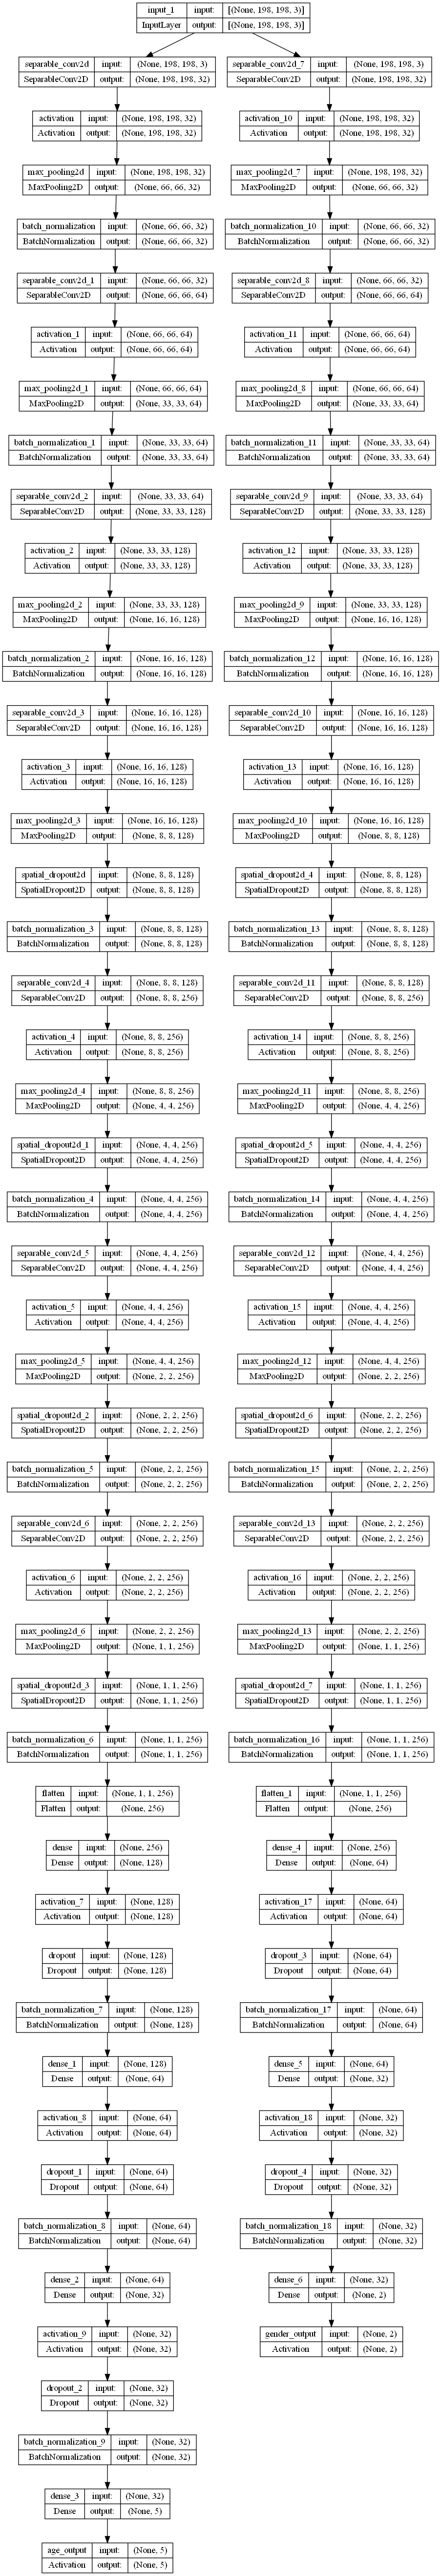

In [18]:
# CNN Model Architecture by splitting the labels (age and gender) for flatten, dropout and activation of the layers.
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

# SeparableConv2D: A variation of the traditional convolution that was to compute it faster than conv2D.
# "same" vs "valid": Output size is the "same" as input size, while valid is padding.
# Source for more detail about padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
# BatchNormalization: To speed up training and to use higher learning rates, making learning easier and to distribute the data uniformly across a mean
#                     that the network sees best.
# MaxPooling2D: To downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window defined by pool_size for each channel.
# SpatialDropout2D: To drop the entire 2D feature maps instead of individual elements as dropout does.
# Strides: The window for shifting.
# Source: https://stackoverflow.com/questions/59634780/correct-order-for-spatialdropout2d-batchnormalization-and-activation-function

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

# Dropouts: To prevent over-fitting the model during training
# relu(Rectifier Linear Unit): Activation to prevent exponential growth in the computation and the emergence of the “vanishing gradient” problem by keeping gradient always high.
# Dense layer: To create fully connected layers, in which (linear) every output depends on every input after usage of Convolutional Layers with fewer parameters by forcing
#               every input to the function and let the neurol network to learn its relation to the output.
# BatchNormalization: To speed up training and use higher learning rates, making learning easier and to guarantee that the values are within a healthy range,
#                     avoiding saturation and vanishing gradients.

def build_gender_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # Why softmax! Source: (https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322)
    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)

    return x

# To assemble the model with their determined height and width.
def assemble_model(width, height):

    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs,
                  outputs = [age_branch, gender_branch],
                  name="face")

    return model

model = assemble_model(198, 198)

from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
model.summary()

Model: "face"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 198, 198, 32  155        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 activation (Activation)        (None, 198, 198, 32  0           ['separable_conv2d[0][0]']       
                                )                                                              

In [22]:
import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

# Learning Rate Schedules in Keras reduces the learning rate by a certain factor after certain no of epochs

#Source:    (https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
#           (https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb)

# According ot several sources (few example of it above), since the learning rate is the most important
# hyperparameter to tune the training in a neural network, it is stated that to reduce learning rate as the training progresses,
# is a good practice for a better outcome (accuracy).

#-------------------------------------------------------------
# Exponential Decay
# def exp_decay(epoch):
#    initial_lrate = 0.001
#    k = 0.2
#    lrate = initial_lrate * np.exp(-k * epoch)  # lr, k are hyperparameters and t=epoch is the iteration number
#    return lrate

#--------------------------------------------------------------

# Step Decay, to drop the learning rate by a factor every few epochs.
def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.4              # % drop rate
	epochs_drop = 5.0       # To drop after every number of epoch
	lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop)) #Fromula for step_decay
	return lrate

# Source: (https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning)
# a low accuracy and huge loss means you made huge errors on a lot of data
# a low accuracy but low loss means you made little errors on a lot of data
# a great accuracy with low loss means you made low errors on a few data (best case)

opt = Adam(learning_rate=0.0)                   # 0.0 means not to be used here.
lrate = LearningRateScheduler(step_decay)       # At the beginning of every epoch, this callback gets the updated learning rate value
#lrate = LearningRateScheduler(exp_decay)

# `binary_crossentropy`, sigmoid activation, scalar target.
# `categorical_crossentropy`, softmax activation, one-hot encoded target.
model.compile(optimizer=opt,
              loss={
                  'age_output': 'categorical_crossentropy',
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy',
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]
# It is this callback that allows a function to invoke during program execution.

In [23]:
# class_weight in Keras: To ensure the unevenness in data distribution (as in age) is sorted out by giving the classes with fewer numbers is assigned more weight to prevent being biased.
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 classes=np.array([0,1,2,3,4]),
                                                 y=np.array(df['age']))

class_weight1 = {'age_output': class_weight}

In [24]:
# To generate batches for train_idx to be able to prevent "too large to fit inside RAM at once so-called memory errors".
train_gen = generate_images(train_idx,
                            is_training=True,
                            batch_size=32)

valid_gen = generate_images(val_idx,
                            is_training=True,
                            batch_size=32)

# fit() as known fit_generator() before 2020: Validation while training the model to evaluate the loss.
history = model.fit(train_gen,
                    steps_per_epoch = len(train_idx)//32,
                    epochs=30,
                    callbacks=callbacks_list,
                    validation_data=valid_gen,
                    validation_steps=len(val_idx)//32)

Epoch 1/30
592/592 [==============================] - 114s 172ms/step - loss: 2.0911 - age_output_loss: 1.1324 - gender_output_loss: 0.5752 - age_output_accuracy: 0.5268 - gender_output_accuracy: 0.6984 - val_loss: 2.0271 - val_age_output_loss: 1.3612 - val_gender_output_loss: 0.4537 - val_age_output_accuracy: 0.4973 - val_gender_output_accuracy: 0.7943 - lr: 0.0080
Epoch 2/30
592/592 [==============================] - 95s 161ms/step - loss: 1.4715 - age_output_loss: 0.8920 - gender_output_loss: 0.3739 - age_output_accuracy: 0.6218 - gender_output_accuracy: 0.8284 - val_loss: 1.6181 - val_age_output_loss: 1.0648 - val_gender_output_loss: 0.3617 - val_age_output_accuracy: 0.5855 - val_gender_output_accuracy: 0.8503 - lr: 0.0080
Epoch 3/30
592/592 [==============================] - 102s 173ms/step - loss: 1.3379 - age_output_loss: 0.7993 - gender_output_loss: 0.3327 - age_output_accuracy: 0.6640 - gender_output_accuracy: 0.8542 - val_loss: 1.5332 - val_age_output_loss: 1.0438 - val_gende

In [25]:
#Source: (https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)
# Save the entire model as a SavedModel.

# save(): To create a SavedModel folder `saved_model`, containing "assets", "saved_model.pb" & "variables".
# The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`.

# The weights are saved in the `variables/` directory.
path = "../models/saved_model/latest_model"
model.save(path) # Saving the above model with its latest best performance today until we apply better architecture.
#model.save('../models/saved_model/latest_model/you_model_name.tf')

# Converting to .h5 file for deployment
#model.save('../models/result/latest_accuracy/bestbyNowon20221127.h5', include_optimizer=True)

INFO:tensorflow:Assets written to: ../models/saved_model/latest_model\assets


INFO:tensorflow:Assets written to: ../models/saved_model/latest_model\assets


In [26]:
from keras.models import load_model
loaded_model = load_model('../models/saved_model/latest_model')
#loaded_model = load_model('./models/saved_model/latest_model/you_model_name.tf')
#loaded_model = load_model('../models/result/latest_accuracy/bestbyNowon20221127.h5', compile=False)

In [1]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Load the image and size it.
def loadImage(filepath):
  test_img = tf.keras.utils.load_img(filepath, target_size=(198, 198))
  test_img = tf.keras.preprocessing.image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

import random as rn
from PIL import Image, ImageFont

# To choose image randomly from dataset
#path=df['file']
#picture = rn.choice(path)

picture='../models/test_img/25-years-old.jpg' # Change the path for other image files if you would like to see more.
age_pred, gender_pred = loaded_model.predict(loadImage(picture))
img = tf.keras.preprocessing.load_img(picture)
plt.imshow(img)
max = -1
count = 0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

#Conditions for outputs
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

ModuleNotFoundError: No module named 'cv2'